In [1]:
import os

weights_path = "/content/densenet10class.pth"
if os.path.exists(weights_path):
    print("Weights file found.")
else:
    print("Weights file not found.")

Weights file found.


In [2]:
print(f"File size: {os.path.getsize(weights_path)} bytes")

File size: 28466844 bytes


In [3]:
import torch

try:
    state_dict = torch.load(weights_path, map_location="cpu")
    print(f"Keys in state_dict: {list(state_dict.keys())[:10]}")  # Display the first 10 keys
    print(f"Total keys in state_dict: {len(state_dict.keys())}")
except Exception as e:
    print(f"Error loading weights file: {e}")

Keys in state_dict: ['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.norm0.num_batches_tracked', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var']
Total keys in state_dict: 727


<ipython-input-3-07eff542b1c2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location="cpu")


Feature Extraction for DenseNet

In [4]:
import zipfile
import random
import os
import torch
from torch.utils.data import Dataset, DataLoader
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Dataset class for loading images from a zip file
class FlowerData(Dataset):
    def __init__(self, data, path_to_data, transform=None):
        self.data = data
        self.path_to_data = path_to_data
        self.transform = transform
        self.file_names, self.label_names, self.label_mapping = self._get_names()

    def _get_names(self):
        file_names = []
        label_names = []
        with zipfile.ZipFile(self.data, 'r') as zip_data:
            all_content = zip_data.namelist()
            for item in all_content:
                if item.startswith(self.path_to_data) and not item.endswith('/'):
                    if item.endswith(('.png', '.jpg', '.jpeg')):
                        file_names.append(item)
                        # Extract class name
                        pattern = r'([^/]+)/[^/]+\.(jpg|jpeg|png)$'
                        match = re.search(pattern, item)
                        label = match.group(1).lower()
                        label_names.append(label)
        # Encode labels
        label_encoder = LabelEncoder()
        label_names = label_encoder.fit_transform(label_names)
        label_mapping = {idx: label for idx, label in enumerate(label_encoder.classes_)}
        return file_names, label_names, label_mapping

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        label = self.label_names[idx]
        with zipfile.ZipFile(self.data, 'r') as zip_data:
            with zip_data.open(file_name) as file:
                image = Image.open(file).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                else:
                    image = transforms.ToTensor()(image)
        return image, label


Feature Extraction Function

In [5]:
def extract_densenet_features(model, dataloader, dataset):
    # Ensure the model is in evaluation mode
    model.eval()

    # Move model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    features = []
    labels = []

    # Extract features and labels
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            output = model(inputs)  # Extract features
            features.append(output.cpu().numpy())
            labels.extend(label.numpy())

    features = np.vstack(features)  # Combine all features into one array
    return features, labels, list(dataset.label_mapping.values())




t-SNE Visualization

In [6]:
def run_tsne(features, labels, classes):
    tsne = TSNE(n_components=2, random_state=42)  # Reduce features to 2D
    reduced_features = tsne.fit_transform(features)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='tab10', s=10)
    legend = plt.legend(handles=scatter.legend_elements()[0], labels=classes, loc="upper right", title="Classes",  prop={'size': 8})
    plt.title("t-SNE Visualization of DenseNet Features-10 class")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()


Main Function for DenseNet + t-SNE

In [7]:
def eval_densenet_tsne(path, testdata, testpath, transform, batch_size, weightspath):
    import os
    # Verify the weights file path
    if not os.path.exists(weightspath):
        raise FileNotFoundError(f"Weight file not found at {weightspath}. Please check the path.")

    # Load the weights into state_dict
    try:
        state_dict = torch.load(weightspath, map_location="cpu")
        print(f"Keys in state_dict before filtering: {list(state_dict.keys())[:5]}")  # Print a few keys to verify

        # Filter out classifier keys
        filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("classifier")}
        print(f"Keys in state_dict after filtering: {list(filtered_state_dict.keys())[:5]}")
    except Exception as e:
        raise RuntimeError(f"Failed to load weights file. Ensure it is a valid PyTorch state_dict. Error: {e}")

    # Load test dataset
    test_dataset = FlowerData(data=path + testdata, path_to_data=testpath, transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load DenseNet model
    model = models.densenet121(weights=None)  # Initialize DenseNet
    model.classifier = nn.Identity()  # Remove classification layer for feature extraction

    # Load weights into the model
    try:
        model.load_state_dict(filtered_state_dict, strict=False)  # Use the already filtered state_dict
        print("Weights loaded with strict=False. Extra keys ignored.")
    except RuntimeError as e:
        raise RuntimeError(f"Error loading weights with strict=False: {e}")

    model.eval()

    # Extract features and labels
    features, labels, classes = extract_densenet_features(model,  test_dataloader, test_dataset)

    # Run t-SNE visualization
    run_tsne(features, labels, classes)











In [13]:
# Define required arguments
args = {
    "path": "/content/",  # Root directory in Colab where the zip is uploaded
    "testdata": "flower10mini.zip",  # The uploaded zip file
    "testpath": "Flower Classification V2/V2/Testing Data/",  # Path inside the zip for the test data
    "batch_size": 16,
    "weightspath": "/content/densenet10class.pth"  # Path to the DenseNet weights file
}

# Check if weight file exists
if not os.path.exists(args["weightspath"]):
    raise FileNotFoundError(f"Weight file not found: {args['weightspath']}")




In [14]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


<ipython-input-7-36e23c07fdf8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weightspath, map_location="cpu")


Keys in state_dict before filtering: ['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var']
Keys in state_dict after filtering: ['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var']
Weights loaded with strict=False. Extra keys ignored.


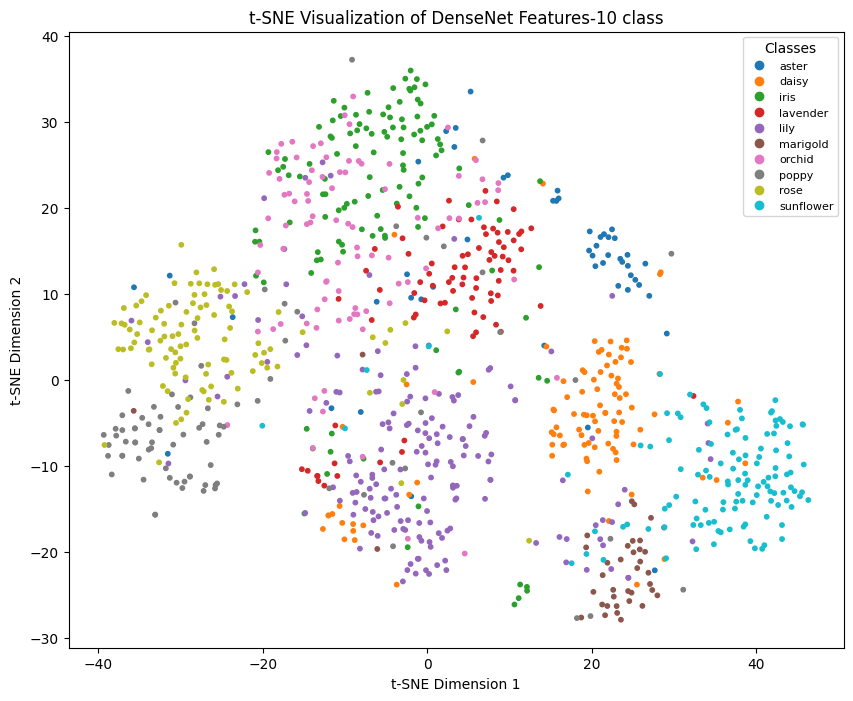

In [15]:
eval_densenet_tsne(
    path=args["path"],
    testdata=args["testdata"],
    testpath=args["testpath"],
    transform=transform,
    batch_size=args["batch_size"],
    weightspath=args["weightspath"]
)


TSNE with image

In [16]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
import numpy as np

# Assuming FlowerData and other components are already defined

# Define the t-SNE plotting function

def plot_tsne_with_images(features, images, labels, title="t-SNE Visualization with Images-10 class"):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(16, 12))

    for feature, image, label in zip(tsne_features, images, labels):
        x, y = feature
        img = np.transpose(image.numpy(), (1, 2, 0))  # Convert to HWC format
        img = np.clip(img, 0, 1)  # Clip values to [0, 1]

        # Overlay the image at the corresponding point
        im = OffsetImage(img, zoom=0.1)  # Smaller zoom factor
        ab = AnnotationBbox(im, (x, y), frameon=False)
        ax.add_artist(ab)

    scatter = ax.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap="tab10", alpha=0.5, s=15)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("t-SNE Dimension 1", fontsize=14)
    ax.set_ylabel("t-SNE Dimension 2", fontsize=14)
    legend = ax.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
    plt.colorbar(scatter)
    plt.show()






<ipython-input-17-f7e3e11d87d6>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weightspath, map_location="cpu")


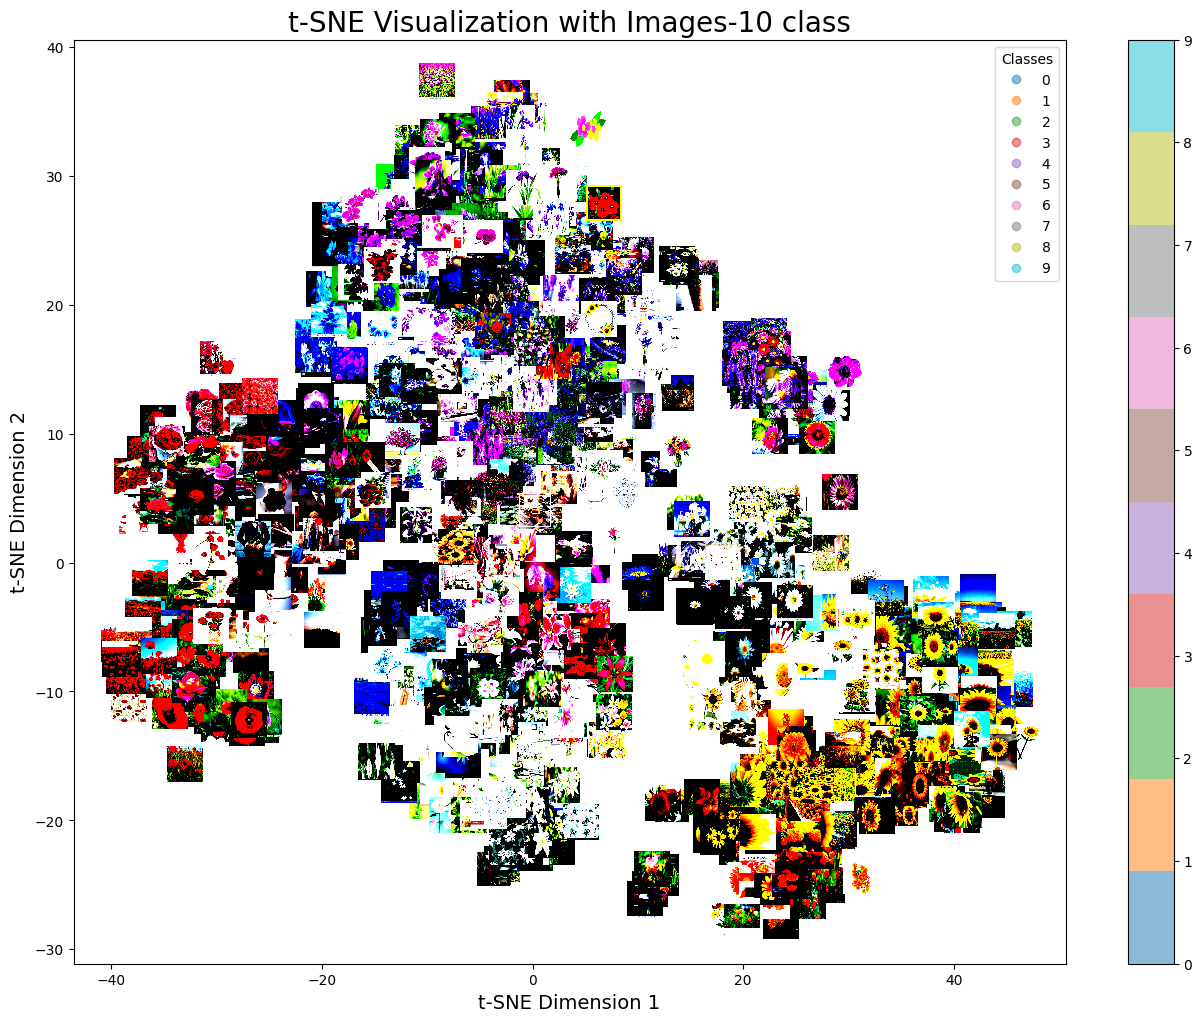

In [17]:
# Function to extract features and prepare data for t-SNE
def tsne_image_visualization(model, dataloader, dataset, weightspath):
    # Remove DenseNet's classifier for feature extraction
    model.classifier = nn.Identity()

    # Load model weights
    state_dict = torch.load(weightspath, map_location="cpu")
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    features = []
    images = []
    labels = []

    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            output = model(inputs)  # Extract features
            features.append(output.cpu().numpy())
            images.extend(inputs.cpu())
            labels.extend(label.numpy())

    features = np.vstack(features)  # Combine all features

    # Call the t-SNE plotting function with images
    plot_tsne_with_images(features, images, labels)

# Initialize Dataset, DataLoader, and Model
args = {
    "path": "/content/",  # Root directory in Colab where the zip is uploaded
    "testdata": "flower10mini.zip",  # The uploaded zip file
    "testpath": "Flower Classification V2/V2/Testing Data/",  # Path inside the zip for the test data
    "batch_size": 16,
    "weightspath": "/content/densenet10class.pth"  # Path to the DenseNet weights file
}

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize Dataset and DataLoader
test_dataset = FlowerData(data=args["path"] + args["testdata"], path_to_data=args["testpath"], transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=args["batch_size"], shuffle=False)

# Initialize the DenseNet model
model = models.densenet121(weights=None)  # Initialize DenseNet without pretrained weights

# Run t-SNE Visualization
tsne_image_visualization(model, test_dataloader, test_dataset, args["weightspath"])